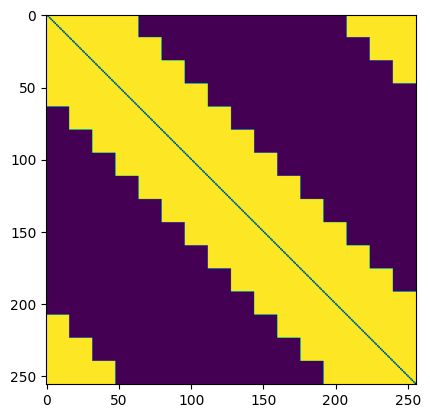

In [69]:
# Function containing all the preprossing data, and run the reconstruction
import scipy.io
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.fft import fft, fftshift
from scipy.signal import hilbert
from scipy.signal.windows import tukey 
import numpy as np
import vectorised_hf as vhf
import h5py 
from matplotlib import colormaps as cm

#data = scipy.io.loadmat('data/ultrasound_reflection_data.mat', variable_names=['__header__', '__version__', '__globals__', 'elementPositions', 'soundSpeed'])
#data2 = scipy.io.loadmat('data/25-01-2024-Open-UST-Heart1-settings.mat')
#samplingFrequency =data2['settings']['AcqSamplingFrequency']
#samplingFrequency = samplingFrequency[0][0]
data = scipy.io.loadmat('data/ultrasound_reflection_data.mat', variable_names=['__header__', '__version__', '__globals__', 'elementPositions', 'samplingFrequency', 'soundSpeed'])
data2 = scipy.io.loadmat('data/ideal_element_positions.mat', variable_names=['angle_TxNorm_to_RxNorm'])
angleMap = data2['angle_TxNorm_to_RxNorm']
angleMask = angleMap > 110
plt.figure(1)
plt.imshow(angleMask)

#  Open the HDF5 file
with h5py.File('data/25-01-2024-Open-UST-Kidney3-data.h5','r') as file: 
    # Load the 3D array
    rcvData =  file['ustData'][:,:,:]

In [70]:
def runDAS(samplingFrequency, elementPositions, soundSpeed, rcvData):
    nTx = 255 # Number of transmitters
    nRx = 255 # Number of receivers
    nt = 2560 # Time samples
    dx = 0.001 # Grid spacing
    Lx = 0.24    # Size of the grid
    Ntx, Nrx, Nt = rcvData.shape
    rcvData2D = rcvData.reshape(Ntx*Nrx, Nt)
    winData2D = vhf.tukey_vectorised(rcvData2D, alpha=0.1, noise_Length=300)
    test_env = vhf.envelope_detection(winData2D)
    print(rcvData2D.shape)
    print(winData2D.shape)
    print(test_env.shape)

    # Create imaging vector
    Xp, Yp = vhf.createImagingVector(dx, Lx)
    # Detector coordinates (example values)
    Xd = elementPositions[:,0]  # X coordinates of detectors
    Yd = elementPositions[:,1]  # Y coordinates of detectors

    # Xd, Xp, Yd and Yp are in 1D, this means that the function cannot run, since they don't have an overlapping dimension to be multipled by
    # The following code makes the 'points' 2D and transposes the matrices so that they are in the right row to column order, before running the distance map function
    Xd2D = Xd.reshape(-1,1)
    Xp2D = Xp.reshape(-1,1)
    Yd2D = Yd.reshape(-1,1)
    Yp2D = Yp.reshape(-1,1)
    Yd2DT = Yd2D.T
    Xd2dT = Xd2D.T
    # Calculate distance map
    distanceMap = vhf.calculateDistanceMap(Xd2dT, Yd2DT, Xp2D, Yp2D)
    #   Convert distance map to time map
    timeMap = vhf.timeMap(distanceMap, soundSpeed)

    # Initialise accumulator
    accumulator = 0
    # accumulated_values = np.zeros(Xd2dT.shape)

    # Make the 2D envelope back into 3D for ease of indexing
    envData3D = test_env.reshape(Ntx, Nrx, Nt)

    # Calculate normal vector of each module
    Nmodule = 16
    deltaTheta = 360/Nmodule
    moduleNormals = np.arange(0,360,deltaTheta)
    moduleNormals2 = moduleNormals.reshape(-1,1)
    moduleNormals2T =  moduleNormals2.T
    # Calculate the normal vector for each individual element
    elementNormals = np.tile(moduleNormals2T,(Nmodule,1))
    elementNormals = elementNormals.flatten('F')
    sinvals = np.sin(elementNormals * np.pi / 180).reshape(-1,1)
    cosvals = np.cos(elementNormals * np.pi / 180).reshape(-1,1)
    elementNormalVec = np.concatenate([sinvals,cosvals],1)


    Npx = Xp.size
    angle_map = np.zeros((Npx, Ntx));
    for idx in range(Ntx):
        vector_map = elementPositions[idx,:] - np.concatenate([Xp2D, Yp2D], 1)
        z = np.sqrt( np.sum(vector_map**2, 1) )
        z = z.reshape(-1,1)
        a = (vector_map /  z).T
        y = elementNormalVec[idx,:].T
        y = y.reshape(-1,1)
        b = np.tile(y, (1, Npx))
        c = a[0,:]*b[0,:] + a[1,:]*b[1,:] 
        c = c.reshape(-1,1).T
        d = np.arccos(c) * 180 / np.pi
        d = d.T
        d = np.squeeze(d)
        angle_map[:,idx] = d



    accumulator = np.zeros_like(Xp2D) 
    for Tx in range(0, nTx, 1): # All the transmiters from 0 to 255,  going up in increments of 8
        for Rx in range (nRx):
        # for Rx in [32]:    
            if angleMask[Tx, Rx]:
                n = np.size(accumulator)
                x = int(np.sqrt(n))
    # for Tx in [0]:
    #     for Rx in [64]:
                # Masking task! 
                # Loop over all the receivers, with only 1 transmitter, the pixel has been vectorised and will not be looped over
                #  Have a 'time' from the transmitter to the pixel, then the pixel to the receiver for the total time
                T1 = timeMap[:,Tx]
                T2 = timeMap[:,Rx] 
                total_time = T1 + T2
                # Convert travel time to sample index
                sample_index = vhf.time_to_sample_index(total_time, samplingFrequency)
                sample_index = sample_index.astype(int)
                valid =  np.logical_and(sample_index < nt-1, sample_index >= 0)
                extract = envData3D[Tx,Rx,sample_index[valid]]  

                # calculate the weighting factor for this tx/rx pair
                beamFactor = 2
                angleWeightingTx = np.abs(np.cos(beamFactor * angle_map[:,Tx] * np.pi / 180))
                angleWeightingRx = np.abs(np.cos(beamFactor * angle_map[:,Rx] * np.pi / 180))
                angleWeighting = angleWeightingTx * angleWeightingRx


                angleWeighting = angleWeighting[np.squeeze(valid)]      
                       
                          
                extract = extract * angleWeighting
                                   

                #plt.figure(1)
                #plt.plot(envData3D[Tx, Rx, :])
                accumulator[valid.T]= accumulator[valid.T] + extract
                np.sum(extract)

                
    x = int(np.sqrt(Npx))
    finalImage = np.reshape(accumulator,(x,x))
    plt.figure(4)
    # Figure out how to change the colour of a plt imshow
    plt.imshow(finalImage, cmap='gray')
    plt.show()
    plt.figure(5)
    plt.imshow(20*np.log10(finalImage), cmap='gray')
    # Figure out how to change the colour of a plt imshow
    plt.show()    
    return finalImage


(2560,)
256.0
256.0
167772160
(65536, 2560)
(65536, 2560)
(65536, 2560)


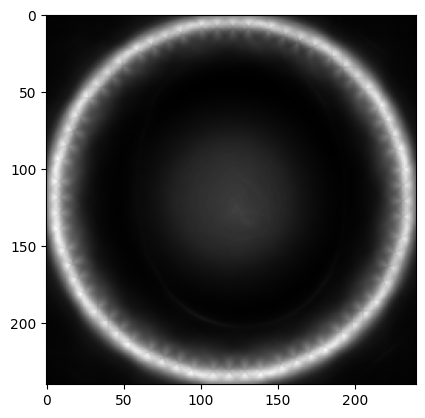

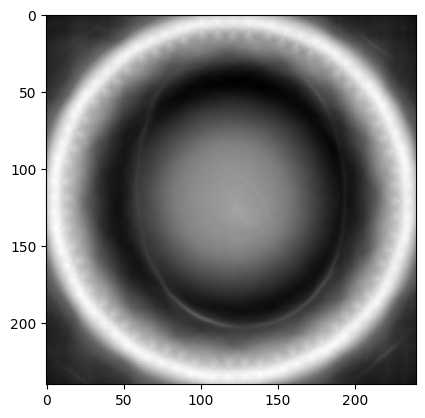

In [71]:
Image = runDAS(samplingFrequency = data['samplingFrequency'], elementPositions = data['elementPositions'], soundSpeed = data['soundSpeed'], rcvData = rcvData)